In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from category_encoders.target_encoder import TargetEncoder
from interpolation import CensusData, BlockInterpolator, CentroidInterpolator, archive, interpolation
from xgboost import XGBClassifier, plot_tree
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import hdbscan

### Notebook Summary:
**Goal:** Determine a way to add geographical specificity to 1850 census records with no known geographic information.\
**Problem:** While disambiguation provides address information for 38% of dwellings in 1850, and adding to that by a few percent is possible through inferrance, there are still dwellings with no geographic specificity beyond dwelling location.
**Method:** Try to train a model to predict block numbers. Train a model to predict clusters of blocks (generated by clustering block centroids for geographical meaning)\
**In this notebook:** Walks through attempts to predict block numbers directly, predicting with different models on centroid clusters, and testing different methods of clustering centroids.

### Get Data

In [2]:
filled_1850 = pd.read_csv("../../data/dwelling_filled_sum_1850_mn_v01.csv")
cd_1850 = pd.read_csv("../../data/cd_1850_XYupdate.csv")
filled_1850.rename(columns = {"CENSUS_WARD_NUM":"Ward_Num", "CENSUS_SERIALP":"CENSUS_SERIALB", "BLOCK_NUM":"block_num", "CENSUS_REEL_HOUSEHOLD":"CENSUS_REEL", "CENSUS_SEX":"CENSUS_SEXB", "CENSUS_PAGENO_HOUSEHOLD":"CENSUS_PAGENUM", "CENSUS_RACE":"CENSUS_RACEB", "CD_X":"cd_X", "CD_Y":"cd_Y"}, inplace = True)
filled_1850.dropna(subset = ["block_num"], inplace = True)

In [14]:
ward_col = "Ward_Num"
dwelling_col = "dwelling_id"
block_col = "block_num"
x_col = "cd_X"
y_col = "cd_Y"

In [15]:
census_data = CensusData(filled_1850, ward_col=ward_col, dwelling_col=dwelling_col, block_col =  block_col, x_col = x_col, y_col = y_col)
census_data.census_records_with_seq()

In [16]:
census_data.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166500 entries, 0 to 166499
Data columns (total 35 columns):
block_num               166500 non-null float64
CD_ADDRESS              166500 non-null object
cd_X                    166500 non-null float64
cd_Y                    166500 non-null float64
CENSUS_AGE              166500 non-null int64
CENSUS_CITY             166500 non-null int64
CENSUS_DWELLING_NUM     166467 non-null float64
CENSUS_DWELLING_SEQ     165763 non-null float64
CENSUS_DWELLING_SIZE    166500 non-null int64
CENSUS_GEOG             166259 non-null object
CENSUS_HH_NUM           166500 non-null int64
CENSUS_ID               12348 non-null object
CENSUS_IMPREL           166500 non-null int64
CENSUS_INDEX            166500 non-null int64
CENSUS_IPUMS_UID        166500 non-null object
CENSUS_LABFORCE         166500 non-null int64
CENSUS_LINE             166500 non-null int64
CENSUS_MARST            166500 non-null int64
CENSUS_NAMEFRST         166273 non-null object
C

In [17]:
census_data.df.tail(1).index[0]

166499

## Block Number Prediction

In [18]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL", "CENSUS_ID", "sequence_order_enum", 'CENSUS_DWELLING_SEQ']
block_boost = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL", "CENSUS_ID", "sequence_order_enum", 'CENSUS_DWELLING_SEQ'])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 80))])

In [19]:
interpolate_blocks = BlockInterpolator(census_data, 10, block_boost, all_cols)
train,test = interpolate_blocks.stratified_train_test(False)
interpolate_blocks.train_test_model(train, test)

In [20]:
interpolate_blocks.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5933 entries, 88490 to 94422
Data columns (total 35 columns):
block_num               5933 non-null float64
CD_ADDRESS              5933 non-null object
cd_X                    5933 non-null float64
cd_Y                    5933 non-null float64
CENSUS_AGE              5933 non-null int64
CENSUS_CITY             5933 non-null int64
CENSUS_DWELLING_NUM     5933 non-null float64
CENSUS_DWELLING_SEQ     5848 non-null float64
CENSUS_DWELLING_SIZE    5933 non-null int64
CENSUS_GEOG             5933 non-null object
CENSUS_HH_NUM           5933 non-null int64
CENSUS_ID               556 non-null object
CENSUS_IMPREL           5933 non-null int64
CENSUS_INDEX            5933 non-null int64
CENSUS_IPUMS_UID        5933 non-null object
CENSUS_LABFORCE         5933 non-null int64
CENSUS_LINE             5933 non-null int64
CENSUS_MARST            5933 non-null int64
CENSUS_NAMEFRST         5933 non-null object
CENSUS_NAMELAST         5933 non-null 

In [21]:
print("Training Score:", interpolate_blocks.train_score)
print("Test Score:", interpolate_blocks.test_score)

Training Score: 1.0
Test Score: 0.2254575707154742


In [22]:
# test_results = test.copy()
# test_results["predicted"] = interpolate_blocks.predict(test)
# display(interpolation.class_analysis(test_results, block_col))

##### Try smote to see if it can cope with the imbalanced classes

In [23]:
boost_model = XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 80)
interpolate_blocks.set_model(boost_model)

In [89]:
train_encoded, test_encoded, train_y, test_y = interpolate_blocks.target_encoder(train, test)
train_sampled_X, train_sampled_y = SMOTE(k_neighbors = 4).fit_resample(train_encoded, train_y)
interpolate_blocks.train_test_model(train_sampled_X, test_encoded, train_sampled_y, test_y)

In [90]:
print("Training Score:", interpolate_blocks.train_score)
print("Test Score:", interpolate_blocks.test_score)

Training Score: 0.9999169435215947
Test Score: 0.24498886414253898


In [ ]:
# test_results = test.copy()
# test_results["predicted"] = interpolate_blocks.predict(test_encoded)
# display(interpolation.class_analysis(test_results, block_col))

##### Smote and undersampling 

In [91]:
over = SMOTE(k_neighbors = 4)
under = RandomUnderSampler()
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [92]:
train_sampled_X, train_sampled_y = pipeline.fit_resample(train_encoded, train_y)
interpolate_blocks.train_test_model(train_sampled_X, test_encoded, train_sampled_y, test_y)

In [93]:
print("Training Score:", interpolate_blocks.train_score)
print("Test Score:", interpolate_blocks.test_score)

Training Score: 0.9997508305647841
Test Score: 0.25092798812175204


In [ ]:
# test_results = test.copy()
# test_results["predicted"] = interpolate_blocks.predict(test_encoded)
# display(interpolation.class_analysis(test_results, block_col))

This clearly didn't work well, and even attempts to deal with imbalanced classes didn't improve the situation much. Let's try the centroid approach.

## Centroids Prediction

The goal of this process is to add a level of geographic specificity to census records for which the linkage process produced no new information. Conceptually this process creates centroids for each block and then clusters them so that each record with a known address is labelled with a cluster based on its block number. The model is trained to predict cluster label on records with known addresses, and then used to predict the cluster of data with no address label. This way every single record will be assigned a centroid with a range of corresponding possible blocks

### RidgeClassifier versus XGboost

#### RidgeClassifier

In [27]:
block_centroids = {ward:{block:interpolation.make_centroid(df_block[x_col], df_block[y_col]) for block, df_block in df.groupby(block_col)} for ward,df in cd_1850.groupby(ward_col)}
centroid_ridge = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL", "CENSUS_ID", "sequence_order_enum", 'CENSUS_DWELLING_SEQ'])),
                        ('classifier', RidgeClassifier())])

In [50]:
centroid_ridge_interpolator = CentroidInterpolator(census_data, 10, centroid_ridge, all_cols, AgglomerativeClustering(6), block_centroids)

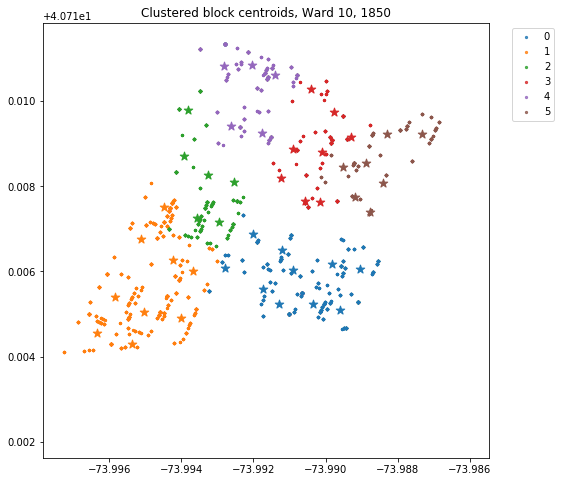

In [51]:
centroid_ridge_interpolator.apply_clustering()
centroid_ridge_interpolator.clustervis()

In [52]:
train,test = centroid_ridge_interpolator.stratified_train_test()
centroid_ridge_interpolator.train_test_model(train, test)

In [53]:
print("Training Score:", centroid_ridge_interpolator.train_score)
print("Test Score:", centroid_ridge_interpolator.test_score)

Training Score: 0.5894385305781674
Test Score: 0.2968476357267951


In [32]:
centroid_ridge_interpolator.model.named_steps["classifier"].coef_

array([[-3.33828920e-01, -1.19848101e-01,  3.50909118e-02,
         2.21293780e-02,  5.69404998e-01, -2.60964258e-02,
        -1.03061309e-01,  8.02179337e-02,  2.20444251e-01,
         7.08721119e-02, -1.00014025e-01, -1.47171094e-02,
        -2.24882456e-02,  1.48720756e-02,  5.50615909e-02,
         1.03764226e-01, -2.60964258e-02, -3.06894556e-02],
       [-5.40353058e-02,  1.14373033e-01,  7.95349082e-02,
        -1.72502230e-01, -4.23286505e-01, -1.42953051e-01,
         5.46117911e-02,  1.19112461e-02, -2.47358791e-01,
         4.74720069e-03,  2.88246096e-01,  8.07719273e-04,
         1.50986015e-02, -4.78919131e-02, -4.88141346e-02,
        -6.66070793e-02, -1.42953051e-01, -1.17087811e-01],
       [-3.34434947e-03, -2.19567095e-02, -2.92224635e-01,
         1.77135941e-01, -2.31376802e-01,  1.94657255e-01,
         3.40454155e-03, -2.82648984e-01, -1.62929593e-01,
        -1.14212824e-01, -6.01450501e-02,  2.71957693e-02,
        -6.77186459e-03,  5.37515132e-02, -5.19988714e

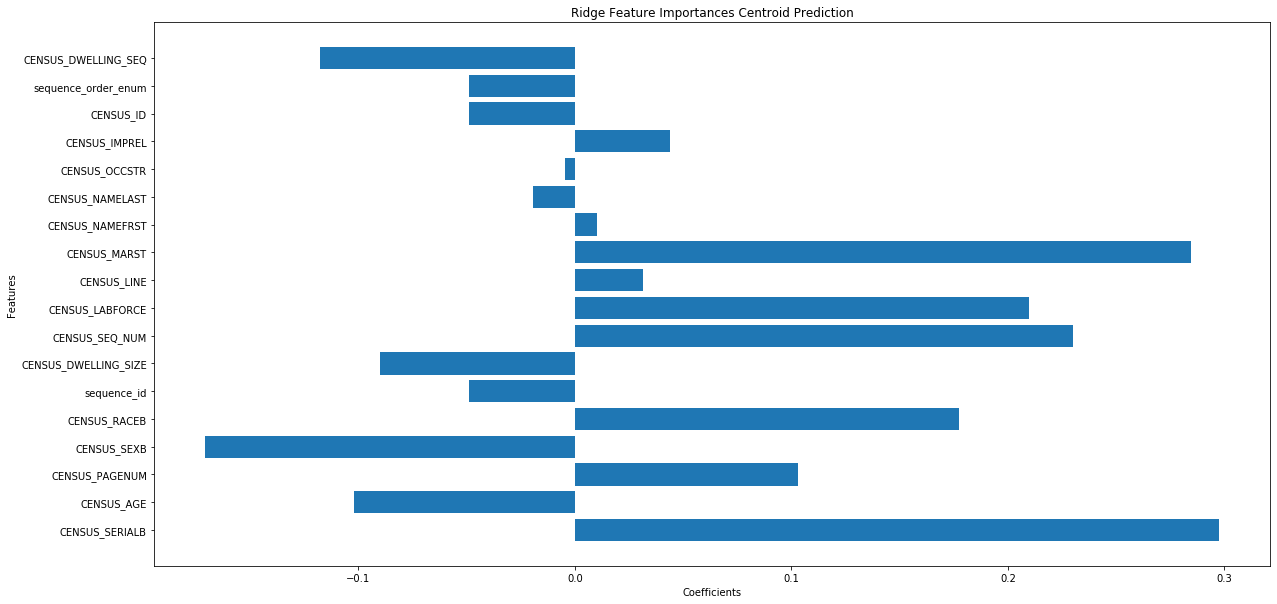

In [54]:
archive.graph_coefs(centroid_ridge_interpolator.model.named_steps["preprocess"].get_feature_names(), centroid_ridge_interpolator.model.named_steps["classifier"].coef_[4], "Ridge Feature Importances Centroid Prediction")

It's interesting to note that the feature importances change drastically between classes.

#### Gradient Boosting

In [57]:
boost_interpolator = CentroidInterpolator(census_data, 10, block_boost, all_cols, AgglomerativeClustering(6), block_centroids)

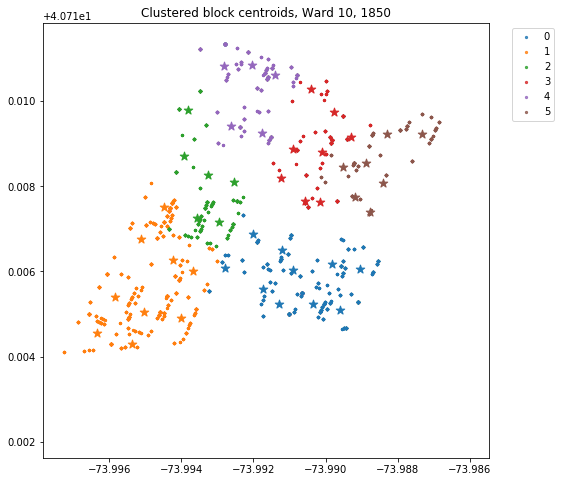

In [58]:
boost_interpolator.apply_clustering()
boost_interpolator.clustervis()

In [59]:
train,test = boost_interpolator.stratified_train_test()
boost_interpolator.train_test_model(train, test)

In [60]:
print("Training Score:", boost_interpolator.train_score)
print("Test Score:", boost_interpolator.test_score)

Training Score: 1.0
Test Score: 0.38266199649737304


In [61]:
test_results = test.copy()
test_results["predicted"] = boost_interpolator.predict(test)
display(interpolation.class_analysis(test_results, "cluster"))

Success rate: 0.38266199649737304
Failure rate: 0.617338003502627


,record count,actual proportion,predicted proportion,predicted correctly,predicted incorrectly,proportion of class predicted correctly,proportion of class predicted incorrectly
0,216,0.189142,0.100701,0.135011,0.222695,0.273148,0.726852
1,374,0.327496,0.613835,0.707094,0.092199,0.826203,0.173797
2,118,0.103327,0.230298,0.112128,0.097872,0.415254,0.584746
3,108,0.094571,0.021891,0.004577,0.150355,0.018519,0.981481
4,247,0.216287,0.021891,0.018307,0.339007,0.032389,0.967611
5,79,0.069177,0.011384,0.022883,0.097872,0.126582,0.873418


Wit 6 clusters boosting worked better than ridge, but with 5 ridge worked better. So this isn't conclusive. Another aspect is tuning xgboost. This can definitely improve the results, but is quite expensive, and not reasonable to do for every possible variant of clustering algorithm.

### Feature Importances Investigation

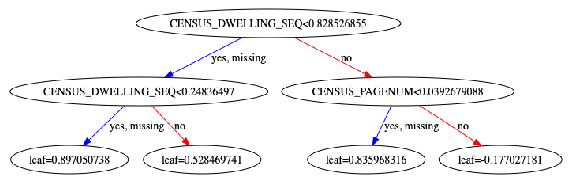

In [62]:
fig, ax = plt.subplots(figsize=(10, 20))
plot_tree(boost_interpolator.model.named_steps["classifier"], num_tree = 10, ax = ax)
plt.show()

#### What would happen if I removed CENSUS_DWELLING_SEQ?

In [63]:
boost_model = XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 80)

In [64]:
no_dwell_seq = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL", "CENSUS_ID", "sequence_order_enum"]
boost_interpolator.set_features(no_dwell_seq)

In [65]:
boost_interpolator.set_model(boost_model)
train_X, test_X, train_y, test_y = boost_interpolator.target_encoder(train, test)
boost_interpolator.train_test_model(train_X, test_X, train_y, test_y)
print("Training Score:", boost_interpolator.train_score)
print("Test Score:", boost_interpolator.test_score)

Training Score: 1.0
Test Score: 0.37215411558669004


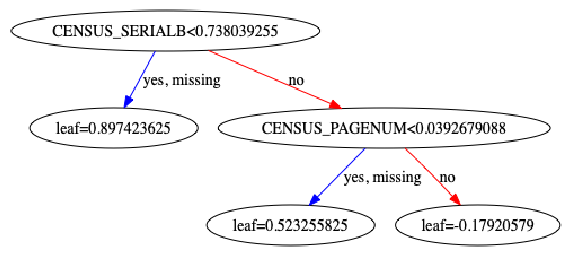

In [66]:
fig, ax = plt.subplots(figsize=(10, 20))
plot_tree(boost_interpolator.model, tree_num = 15, ax = ax)

#### What about with no demographic information?

In [67]:
no_demo = ["CENSUS_SERIALB", "CENSUS_PAGENUM", "sequence_id", "CENSUS_OCCSTR", "sequence_order_enum", 'CENSUS_DWELLING_SEQ']
boost_interpolator.set_features(no_demo)
train_X, test_X, train_y, test_y = boost_interpolator.target_encoder(train, test)
boost_interpolator.train_test_model(train_X, test_X, train_y, test_y)
print("Training Score:", boost_interpolator.train_score)
print("Test Score:", boost_interpolator.test_score)

Training Score: 1.0
Test Score: 0.4124343257443082


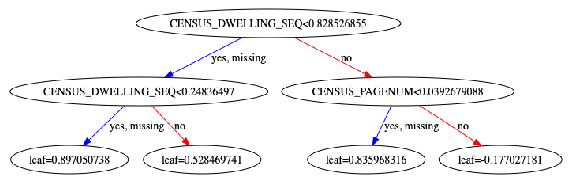

In [68]:
fig, ax = plt.subplots(figsize=(10, 20))
plot_tree(boost_interpolator.model, tree_num = 15, ax = ax)

#### Without demographic information and without CENSUS_DWELLING_SEQ

In [69]:
no_demo_no_seq = ["CENSUS_SERIALB", "CENSUS_PAGENUM", "sequence_id", "CENSUS_OCCSTR", "sequence_order_enum"]
boost_interpolator.set_features(no_demo_no_seq)
train_X, test_X, train_y, test_y = boost_interpolator.target_encoder(train, test)
boost_interpolator.train_test_model(train_X, test_X, train_y, test_y)
print("Training Score:", boost_interpolator.train_score)
print("Test Score:", boost_interpolator.test_score)

Training Score: 1.0
Test Score: 0.4211908931698774


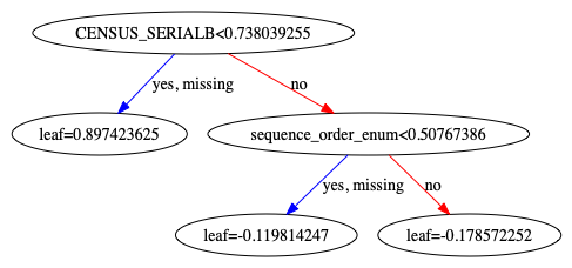

In [70]:
fig, ax = plt.subplots(figsize=(10, 20))
plot_tree(boost_interpolator.model, tree_num = 60, ax = ax)
plt.show()

Including all possible features clearly helps the model, but the trees are positive indications because they suggest the model is using enumeration patterns

### Clustering Algorithm Selection

There are several possible clustering algorithms that could make sense for this process. Factors to consider:
- how many clusters are created?
    - the more clusters we can predict accurately, the more geographic specificity is added
- how accurately can the boosting model predict the results
- how geographically relevant are the results?
    - ei: clustering that involves noise may not be ideal, because the model will treat this as just another category and records labelled this way won't be understand as well

#### Kmeans

In [73]:
kmeans_interpolator = CentroidInterpolator(census_data, 10, block_boost, all_cols, KMeans(5), block_centroids)

In [74]:
#This is really unstable, need to use kmeans_best
for n in (4, 5, 6, 7, 8):
    print("{} clusters".format(n))
    algo = KMeans(n)
    kmeans_interpolator.clustering_algo_tuning(algo, clustervis= False)
    print("Training Score:", kmeans_interpolator.train_score)
    print("Test Score:", kmeans_interpolator.test_score)
    print("\n")

4 clusters
Training Score: 1.0
Test Score: 0.40789473684210525


5 clusters
Training Score: 1.0
Test Score: 0.46307053941908716


6 clusters
Training Score: 1.0
Test Score: 0.43622047244094486


7 clusters
Training Score: 1.0
Test Score: 0.44529914529914527


8 clusters
Training Score: 1.0
Test Score: 0.36466165413533835




In [75]:
kmeans_interpolator.set_model(block_boost)
kmeans_results = {n:kmeans_interpolator.kmeans_best(n) for n in (4,5,6,7,8)}

n is 4 and it's the 0th iteration
n is 4 and it's the 50th iteration
n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration
n is 6 and it's the 0th iteration
n is 6 and it's the 50th iteration
n is 7 and it's the 0th iteration
n is 7 and it's the 50th iteration
n is 8 and it's the 0th iteration
n is 8 and it's the 50th iteration


In [77]:
kmeans_scores = pd.DataFrame({key:value[0] for key, value in kmeans_results.items()}, index=["Best Score"]).T.rename_axis("Number of Clusters").reset_index()
display(kmeans_scores)

,Number of Clusters,Best Score
0,4,0.666667
1,5,0.513951
2,6,0.496454
3,7,0.512799
4,8,0.529783


Kmeans results can be quite unstable. Taking the best of 100 runs seems to provide a reasonable amount of consistancy, but 

#### Agglomerative Clustering

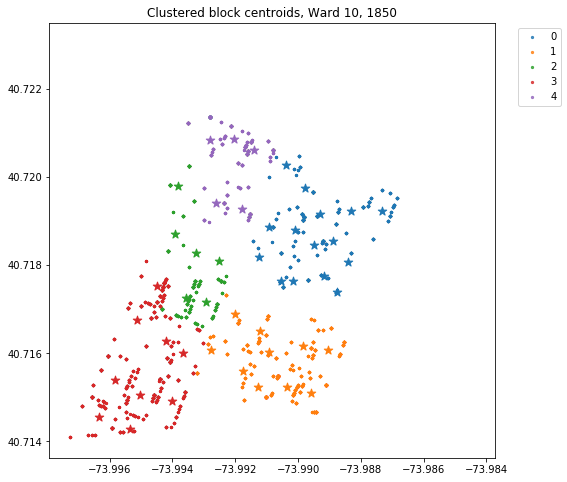

In [78]:
agg_interpolator = CentroidInterpolator(census_data, 10, block_boost, all_cols, AgglomerativeClustering(5), block_centroids)
agg_interpolator.apply_clustering()
agg_interpolator.clustervis()

**Evaluate:** Geographic Specificity 
This seems like it would work well for predicting geographically specific areas

In [79]:
train,test = agg_interpolator.stratified_train_test(stratified = True)
agg_interpolator.train_test_model(train, test)
print("Training Score:", agg_interpolator.train_score)
print("Test Score:", agg_interpolator.test_score)

Training Score: 1.0
Test Score: 0.3028953229398664


In [80]:
agglomerative_results = {}
for n in (4,5,6,7,8):
    algo = AgglomerativeClustering(n)
    agg_interpolator.clustering_algo_tuning(algo, clustervis= False)
    agglomerative_results[n] = agg_interpolator.test_score

This is  stable over reruns in comparison with kmeans

#### DBScan

In [81]:
db_interpolator = CentroidInterpolator(census_data, 10, block_boost, all_cols, DBSCAN(), block_centroids)

0.0011


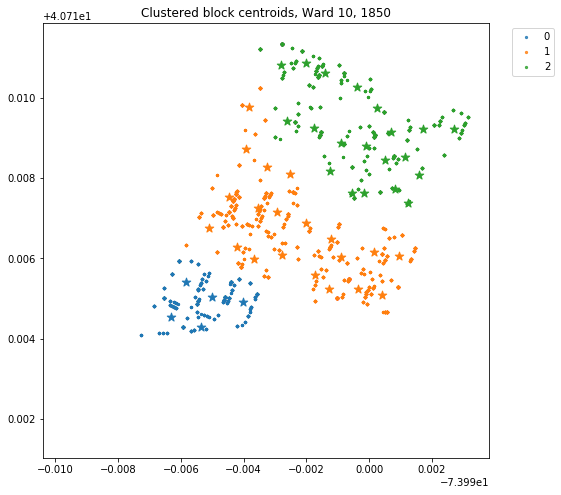

Test Score: 0.5772029102667745
0.001


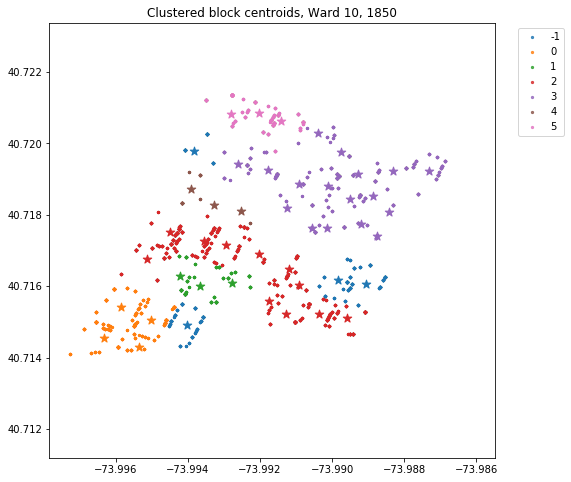

Test Score: 0.4026958719460826
0.00101


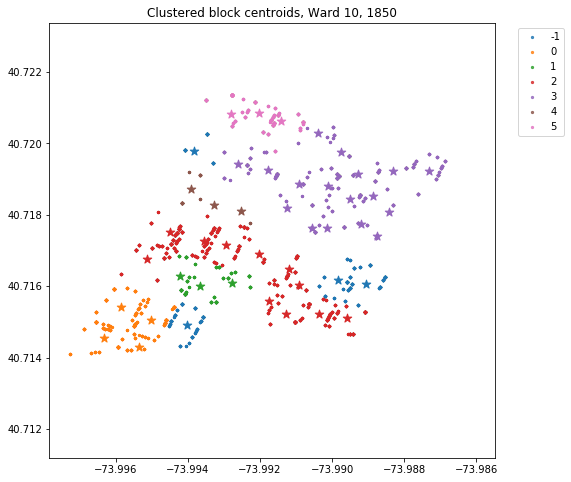

Test Score: 0.4026958719460826
0.0009


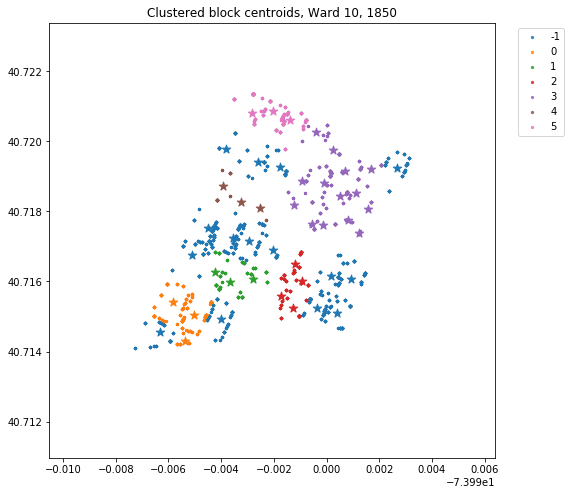

Test Score: 0.31841652323580033


In [82]:
dbscan_results = {}
eps_ops = [0.0011, 0.001, 0.00101, 0.0009]
for n in eps_ops:
    print(n)
    algo = DBSCAN(eps = n,min_samples = 3)
    db_interpolator.clustering_algo_tuning(algo)
    dbscan_results[len(np.unique(db_interpolator.clusters))] = db_interpolator.test_score
    print("Test Score:", db_interpolator.test_score)

This is stable, unlike kmeans, but deciding what works needs to be done carefully, since the noise label is treated like another cluster but can be spread out accross geographies, so may not help with answering the geographic specificity question.

#### hdbscan

In [83]:
hdb_interpolator = CentroidInterpolator(census_data, 10, block_boost, all_cols, hdbscan.HDBSCAN(), block_centroids)

min_samples: 2


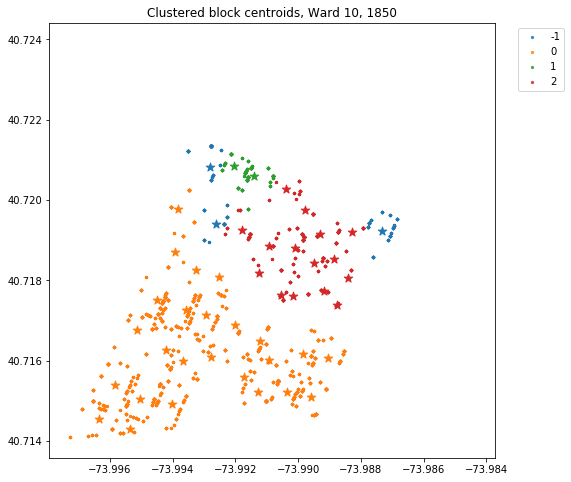

0.7227272727272728
min_samples: 3


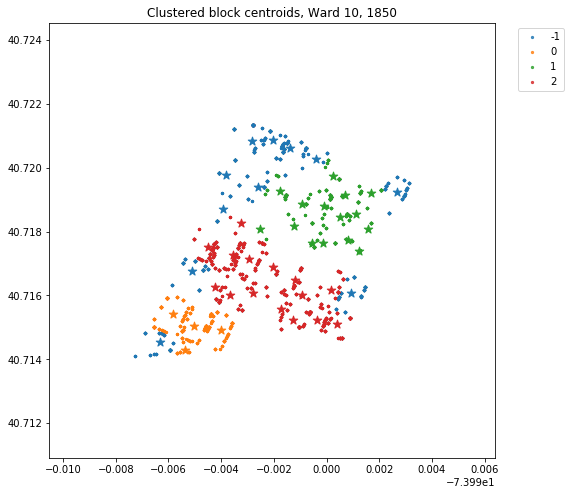

0.4550853749072012
min_samples: 4


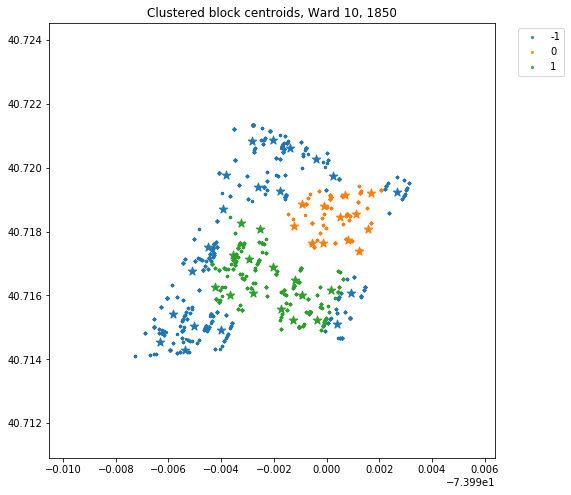

0.456686291000841
min_samples: 5


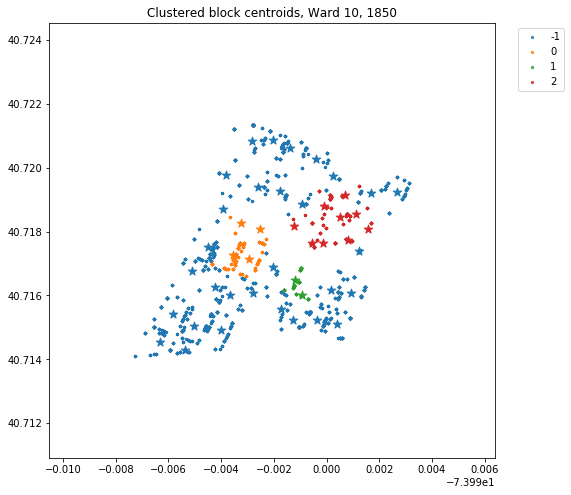

0.7129060579455663


In [84]:
hdb_results = {}
for n in (2,3,4,5):
    print("min_samples:", n)
    algo = hdbscan.HDBSCAN(min_cluster_size=2, min_samples = n)
    hdb_interpolator.clustering_algo_tuning(algo)
    print(hdb_interpolator.test_score)
    hdb_results[len(np.unique(hdb_interpolator.clusters))] = hdb_interpolator.test_score
    

It doesn't seem that this would work well for our purpose since in cases when it performs well it doesn't seem to add much geographic specificity, but it does get fairly high scores in some cases, and depending on how few clusters we're willing to use and consider useful, it perhaps has some potential

#### Cluster algorithms results summary

In [85]:
all_clust_results = [{key:value[0] for key, value in kmeans_results.items()}, agglomerative_results, dbscan_results, hdb_results]
pd.DataFrame(all_clust_results, index = ["Kmeans", "Agglomerative", "dbscan", "hdb"]).T.sort_index()

,Kmeans,Agglomerative,dbscan,hdb
3,NaN,NaN,0.577203,0.456686
4,0.666667,0.456540,NaN,0.712906
5,0.513951,0.302895,NaN,NaN
6,0.496454,0.382662,NaN,NaN
7,0.512799,0.439631,0.318417,NaN
8,0.529783,0.316114,NaN,NaN


### Tune XGBoost Model